markstro
3/27/2020

compute the solar table for the HRUs for each day of the year

In [1]:
import numpy as np
import pandas as pd
import fiona 
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib import cm
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
gdb_path = 'c:/Users/markstro/work1.1/GIS/GFv1.1_v2e.gdb'

# These are the values from the PRMS parameter paramdb
hru_lat_fn = 'c:/Users/markstro/work1.1/paramdb_v1.1/paramdb_master/hru_lat.csv'
hru_slope_fn = 'c:/Users/markstro/work1.1/paramdb_v1.1/paramdb_master/hru_slope.csv'
hru_aspect_fn = 'c:/Users/markstro/work1.1/paramdb_v1.1/paramdb_master/hru_aspect.csv'

soltab_solt_fn = 'c:/Users/markstro/work1.1/soltab/soltab_solt_GF_v1.1.csv'

In [3]:
eccentricity = 0.01671
daysyr = 365.242
degday = 360.0 / daysyr
radians = np.pi / 180.0
degdayrad = degday * radians
pi_12 = 12.0 / np.pi
two_pi = 2.0 * np.pi
njday = 366

In [5]:
obliquity = np.zeros(366)
solar_declination = np.zeros(366)

for jday in range(1,njday + 1):
    jday_f = float(jday)
    obliquity[jday-1] = 1.0 - (eccentricity * np.cos((float(jday + 1) - 3.0) * degdayrad))
    
    y = degdayrad * (jday_f - 1.0)
    y2 = 2.0 * y
    y3 = 3.0 * y
    solar_declination[jday-1] = 0.006918 - 0.399912 * np.cos(y) + 0.070257 * np.sin(y) \
                                - 0.006758 * np.cos(y2) + 0.000907 * np.sin(y2) \
                                - 0.002697 * np.cos(y3) + 0.00148 * np.sin(y3)
    
    print(jday, obliquity[jday-1], solar_declination[jday-1])

1 0.983292472487224 -0.402449
2 0.98329 -0.4010661330849535
3 0.983292472487224 -0.3995503696411535
4 0.9832998892172151 -0.3979024022358868
5 0.9833122479951476 -0.39612298552455943
6 0.9833295451637 -0.3942129353835142
7 0.9833517756041374 -0.39217312797559595
8 0.9833789327378271 -0.39000449875049376
9 0.9834110085281837 -0.3877080413820252
10 0.9834479934830496 -0.3852848066446528
11 0.9834898766575019 -0.3827359012316472
12 0.9835366456570924 -0.38006248651742647
13 0.9835882866415155 -0.37726577726671123
14 0.983644784328704 -0.37434704029323684
15 0.9837061219993504 -0.3713075930708613
16 0.9837722815018562 -0.3681488022999973
17 0.9838432432577029 -0.36487208243237385
18 0.9839189862672449 -0.36147889415721396
19 0.9839994881159256 -0.35797074285197517
20 0.9840847249809093 -0.35434917700085955
21 0.9841746716381312 -0.3506157865843539
22 0.9842693014697624 -0.34677220144309695
23 0.9843685864720867 -0.34282008961941085
24 0.9844724972637875 -0.33876115567985404
25 0.9845810030

In [6]:
hru_aspect_df = pd.read_csv(hru_aspect_fn)
hru_aspect_df.sort_values(by=['$id'])
hru_aspect = hru_aspect_df['hru_aspect'].values
print(hru_aspect)
nhru = len(hru_aspect)
print("nhru = " + str(nhru))

hru_slope_df = pd.read_csv(hru_slope_fn)
hru_slope_df.sort_values(by=['$id'])
hru_slope = hru_slope_df['hru_slope'].values
print(hru_slope)

hru_lat_df = pd.read_csv(hru_lat_fn)
hru_lat_df.sort_values(by=['$id'])
hru_lat = hru_lat_df['hru_lat'].values
print(hru_lat)

[1.02156074e+02 1.69971111e+02 2.57530982e+02 ... 6.56140000e+01
 2.40000000e-01 4.40900000e+00]
nhru = 114958
[0.026853 0.033231 0.056251 ... 0.072    0.195    0.074   ]
[41.108346 41.131604 41.145762 ... 46.179    46.179    46.179   ]


In [7]:
#  This is the sunrise equation
#  Lat is the latitude
#  Solar_declination is the declination of the sun on a day
#  T is the angle hour from the local meridian (local solar noon) to the
#  sunrise (negative) or sunset (positive).  The Earth rotates at the angular
#  speed of 15 degrees/hour (2 pi / 24 hour in radians) and, therefore, T/15 degress (T*24/pi
#  in radians) gives the time of sunrise as the number of hours before the local
#  noon, or the time of sunset as the number of hours after the local noon.
#  Here the term local noon indicates the local time when the sun is exactly to
#  the south or north or exactly overhead.
#

# T = np.zeros((njday,nhru))

def compute_t(Lat, Solar_declination):
#    if tx < -1.0:
#        T = np.pi
#    elif tx > 1.0:
#        T = 0.0
#    else:
#        T = np.arccos(tx)

    nr = len(Solar_declination)
    nc = len(Lat)
    T = np.zeros((nr,nc))
    
    for irow in range(nr):
        for icol in range(nc):
            tx = -np.tan(Lat[icol]) * np.tan(Solar_declination[irow])
            if tx < -1.0:
                T[irow,icol] = np.pi
            elif tx > 1.0:
                T[irow,icol] = 0.0
            else:
                T[irow,icol] = np.arccos(tx)
    return T

In [8]:
#  This is the radian angle version of FUNC3 (eqn 6) from Swift, 1976
#  or Lee, 1963 equation 5.
#  func3 (R4) is potential solar radiation on the surface cal/cm2/day
#  V (L2) latitude angle hour offset between actual and equivalent slope
#  W (L1) latitude of the equivalent slope
#  X (T3) hour angle of sunset on equivalent slope
#  Y (T2) hour angle of sunrise on equivalent slope
#  R1 solar constant for 60 minutes
#  sd is Solar_declination declination of sun

def func3(v, w, x, y, r1, sd):    
    ret = r1 * pi_12 * (np.sin(sd) * np.sin(w) * (x - y) + np.cos(sd) * np.cos(w) * (np.sin(x + v) - np.sin(y + v)))
    return ret

In [9]:
# These np functions are vectorized, all variables are np arrays

sl = np.arctan(hru_slope)
cossl = np.cos(sl)
a = radians * hru_aspect

# x0 latitude of HRUs
x0 = hru_lat * radians

# x1 latitude of equivalent slope
x1 = np.arcsin(cossl * np.sin(x0) + np.sin(sl) * np.cos(x0) * np.cos(a))

# d1 is the denominator of equation 12, Lee, 1963
d1 = cossl * np.cos(x0) - np.sin(sl) * np.sin(x0) * np.cos(a)

# x2 is the difference in longitude between the location of
# the HRU and the equivalent horizontal surface expressed in angle hour
# This is equation 12 from Lee, 1963
#x2 = ATAN(SIN(sl)*SIN(a)/d1)
x2 = np.arctan(np.sin(sl) * np.sin(a) / d1)

#      IF ( d1<0.0uD0 ) x2 = x2 + PI
x2 = np.where(d1 >= 0, x2, x2 + np.pi)

# r0 is the minute solar constant cal/cm2/min
r0 = 2.0
# r0 could be 1.95 (Drummond, et al 1968)

#for ihru in range(nhru):
#            CALL compute_soltab(obliquity, Solar_declination, Hru_slope(n), Hru_aspect(n), &
#     &                      Hru_lat(n), Hru_cossl(n), Soltab_potsw(1, n), &
#     &                      Soltab_sunhrs(1, n), Hru_type(n), n)


#r1 = np.zeros(njday)

#for jday in range(1, njday + 1):

#    jday_f = float(jday)
#    d = solar_declination[jday-1]
#    print(jday, d)
    
# This is adjusted to express the variability of available insolation as
# a function of the earth-sun distance.  Lee, 1963, p 16.
# r1 is the hour solar constant cal/cm2/hour
# r0 is the minute solar constant cal/cm2/min
# 60.0D0 is minutes in an hour
# Obliquity is the obliquity of the ellipse of the earth's orbit around the sun. E
# is also called the radius vector of the sun (or earth) and is the ratio of
# the earth-sun distance on a day to the mean earth-sun distance.
# obliquity = ~23.439 (obliquity of sun)
# vectorized on jday
r1 = 60.0 * r0 / (obliquity * obliquity)

In [11]:
#  compute_t is the sunrise equation.
#  t7 is the hour angle of sunset on the equivalent slope
#  t6 is the hour angle of sunrise on the equivalent slope
# t is two dimensions array [jday,nhru]
# x0, x1, x2 are nhru arrays
t = compute_t(x1, solar_declination)
print("t[0,0] = ", t[0,0])
print("x1[0] = ", x1[0])
print("x2[0] = ", x2[0])
print("solar_declination[0] = ", solar_declination[0])

t7 = np.zeros((njday,nhru))
t6 = np.zeros((njday,nhru))
for jd in range(njday):
    for ihru in range(nhru):
        t7[jd,ihru] = t[jd,ihru] - x2[ihru]
        t6[jd,ihru] = -t[jd,ihru] - x2[ihru]
#    print(jday, t7)
#    print(jday, t6)
print("t6[0,0] = ", t6[0,0])
print("t7[0,0] = ", t7[0,0])
    
#  compute_t is the sunrise equation.
#  t1 is the hour angle of sunset on a hroizontal surface at the HRU
#  t0 is the hour angle of sunrise on a hroizontal surface at the HRU
t = compute_t(x0, solar_declination)
t1 = t
t0 = -t

#    print(jday, t1)
#    print(jday, t0)
    
# For HRUs that have an east or west direction component to their aspect, the
# longitude adjustment (moving the effective slope east or west) will cause either:
# (1) sunrise to be earlier than at the horizontal plane at the HRU
# (2) sunset to be later than at the horizontal plane at the HRU
# This is not possible. The if statements below check for this and adjust the
# sunrise/sunset angle hours on the equivalent slopes as necessary.
#
# t3 is the hour angle of sunrise on the slope at the HRU
# t2 is the hour angle of sunset on the slope at the HRU
#        IF ( t7>t1 ) THEN
#          t3 = t1
#        ELSE
#          t3 = t7
#        ENDIF
t3 = np.where(t7 < t1, t1, t7) 
        
#        IF ( t6<t0 ) THEN
#          t2 = t0
#        ELSE
#          t2 = t6
#        ENDIF
t2 = np.where(t6 < t0, t0, t6) 
    
#    print(jday, t3)
#    print(jday, t2)
    
    
    

t[0,0] =  1.1949966206306013
x1[0] =  0.7115244204395723
x2[0] =  0.03465515977447604
solar_declination[0] =  -0.402449
t6[0,0] =  -1.2296517804050773
t7[0,0] =  1.1603414608561253


In [14]:
#t[jd,ihru]

jd = 0
ihru = 5

print("t0 ", t0[jd,ihru])
print("t1 ", t1[jd,ihru])
print("t2 ", t2[jd,ihru])
print("t3 ", t3[jd,ihru])
print("t6 ", t6[jd,ihru])
print("t7 ", t7[jd,ihru])

t0  -1.1897765210395104
t1  1.1897765210395104
t2  -1.1897765210395104
t3  1.1897765210395104
t6  -1.2686808897062514
t7  1.1217651227305236


In [15]:
#  solt is Swift's R4 (potential solar radiation on a sloping surface cal/cm2/day)
#  Swift, 1976, equation 6
#  sunh is the number of hours of direct sunlight (sunset minus sunrise) converted
#  from angle hours in radians to hours (24 hours in a day divided by 2 pi radians
#  in a day).

# Need to do an actual hru loop

solt = np.zeros((njday,nhru))
sunh = np.zeros((njday,nhru))

for jday in range(njday):
    for ihru in range(nhru):
        if sl[ihru] == 0.0:
            solt[jday,ihru] = func3(0.0, x0[ihru], t1[jday,ihru], t0[jday,ihru], r1[jday], solar_declination[jday])
            sunh[jday,ihru] = (t1[jday,ihru] - t0[jday,ihru]) * pi_12
            
        else:
            if t3[jday,ihru] < t2[jday,ihru]:
                t2[jday,ihru] = 0.0
                t3[jday,ihru] = 0.0

            t6[jday,ihru] = t6[jday,ihru] + two_pi
            
            if t6[jday,ihru] < t1[jday,ihru]:
                solt[jday,ihru] = func3(x2[ihru], x1[ihru], t3[jday,ihru], t2[jday,ihru], r1[jday], solar_declination[jday]) \
                            + func3(x2[ihru], x1[ihru], t1[jday,ihru], t6[jday,ihru], r1[jday], solar_declination[jday])
                sunh[jday,ihru] = (t3[jday,ihru] - t2[jday,ihru] + t1[jday,ihru] - t6[jday,ihru]) * pi_12
                
            else:
                t7[jday,ihru] = t7[jday,ihru] - two_pi
                if t7[jday,ihru] > t0[jday,ihru]:
                    solt[jday,ihru] = func3(x2[ihru], x1[ihru], t3[jday,ihru], t2[jday,ihru], r1[jday], solar_declination[jday]) \
                                + func3(x2[ihru], x1[ihru], t7[jday,ihru], t0[jday,ihru], r1[jday], solar_declination[jday])
                    sunh[jday,ihru] = (t3[jday,ihru] - t2[jday,ihru] + t7[jday,ihru] - t0[jday,ihru]) * pi_12
                    
                else:
                    solt[jday,ihru] = func3(x2[ihru], x1[ihru], t3[jday,ihru], t2[jday,ihru], r1[jday], solar_declination[jday])
                    sunh[jday,ihru] = (t3[jday,ihru] - t2[jday,ihru]) * pi_12


In [ ]:
print(type(solt))
print(solt.shape)
#print(solt)
print(solt[:,0])
print(len(solt[:,0]))


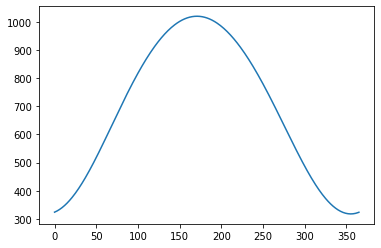

In [21]:
plt.plot(solt[:,5])
plt.show()

In [ ]:
 # gf v1.0 values
    prms_soltab_1 = [294.162,295.476,296.914,298.475,300.159,301.966,303.895,305.945,308.117,310.408,312.820,315.349,317.997,
    320.761,323.642,326.637,329.747,332.969,336.303,339.747,343.301,346.962,350.730,354.603,358.580,362.658,366.837,371.115,
    375.490,379.960,384.524,389.179,393.924,398.757,403.677,408.680,413.765,418.930,424.172,429.491,434.883,440.346,445.878,
    451.476,457.140,462.865,468.649,474.492,480.389,486.338,492.338,498.385,504.478,510.614,516.790,523.004,529.253,535.536,
    541.849,548.191,554.558,560.949,567.361,573.792,580.239,586.700,593.173,599.656,606.145,612.640,619.137,625.635,632.131,
    638.623,645.109,651.588,658.056,664.512,670.954,677.380,683.787,690.175,696.541,702.883,709.200,715.490,721.750,727.980,
    734.177,740.340,746.468,752.558,758.609,764.620,770.589,776.515,782.395,788.230,794.017,799.755,805.442,811.079,816.662,
    822.191,827.665,833.082,838.441,843.742,848.983,854.162,859.280,864.334,869.324,874.249,879.108,883.900,888.623,893.278,
    897.862,902.376,906.818,911.188,915.484,919.706,923.854,927.925,931.920,935.838,939.678,943.440,947.122,950.725,954.247,
    957.687,961.046,964.323,967.516,970.626,973.651,976.592,979.447,982.217,984.900,987.496,990.004,992.425,994.757,997.001,
    999.155,1001.220,1003.195,1005.080,1006.873,1008.576,1010.187,1011.707,1013.135,1014.470,1015.713,1016.863,1017.921,
    1018.885,1019.756,1020.534,1021.218,1021.809,1022.306,1022.710,1023.019,1023.235,1023.357,1023.386,1023.321,1023.162,
    1022.910,1022.564,1022.126,1021.594,1020.970,1020.253,1019.443,1018.542,1017.549,1016.464,1015.288,1014.021,1012.664,
    1011.216,1009.679,1008.053,1006.337,1004.534,1002.642,1000.663,998.596,996.444,994.205,991.881,989.472,986.979,984.402,
    981.742,979.000,976.176,973.270,970.284,967.218,964.073,960.849,957.548,954.169,950.714,947.183,943.577,939.896,936.142,
    932.316,928.417,924.447,920.407,916.297,912.118,907.871,903.556,899.175,894.729,890.217,885.642,881.004,876.303,871.542,
    866.720,861.839,856.899,851.902,846.848,841.739,836.576,831.359,826.089,820.769,815.398,809.977,804.509,798.994,793.433,
    787.827,782.178,776.487,770.754,764.982,759.171,753.323,747.440,741.521,735.570,729.586,723.572,717.529,711.459,705.363,
    699.242,693.098,686.932,680.747,674.544,668.324,662.089,655.841,649.582,643.313,637.036,630.754,624.466,618.177,611.887,
    605.599,599.314,593.035,586.763,580.500,574.249,568.012,561.790,555.586,549.402,543.240,537.102,530.990,524.908,518.856,
    512.837,506.853,500.907,495.001,489.137,483.317,477.543,471.819,466.145,460.525,454.960,449.453,444.005,438.620,433.300,
    428.045,422.860,417.745,412.703,407.736,402.846,398.036,393.305,388.658,384.096,379.620,375.233,370.936,366.731,362.620,
    358.604,354.686,350.866,347.146,343.529,340.015,336.605,333.302,330.106,327.019,324.041,321.175,318.421,315.780,313.254,
    310.843,308.548,306.370,304.310,302.369,300.547,298.846,297.266,295.807,294.470,293.255,292.164,291.196,290.352,289.632,
    289.037,288.567,288.221,288.001,287.907,287.938,288.094,288.376,288.784,289.317,289.976,290.760,291.670,292.704,293.863]

In [ ]:
diff = solt[:,0] - prms_soltab_1
#print(diff)
plt.plot(diff)
plt.show()
print(max(prms_soltab_1))


In [ ]:
print(solt[:,99999])
plt.plot(solt[:,99999])
plt.show()

In [ ]:
# gf v1.0 values
    
prms_soltab_100000 = [307.216,308.542,309.991,311.566,313.264,315.085,317.029,319.095,321.282,323.590,326.018,328.564,331.228,
334.010,336.907,339.920,343.046,346.284,349.634,353.094,356.663,360.339,364.120,368.006,371.995,376.085,
380.274,384.560,388.943,393.420,397.989,402.648,407.396,412.230,417.148,422.148,427.229,432.387,437.621,
442.928,448.307,453.755,459.269,464.848,470.488,476.188,481.946,487.758,493.622,499.536,505.498,511.505,
517.554,523.644,529.771,535.933,542.128,548.354,554.607,560.886,567.188,573.511,579.852,586.209,592.579,
598.961,605.352,611.749,618.151,624.556,630.960,637.362,643.760,650.151,656.534,662.907,669.266,675.612,
681.940,688.251,694.541,700.808,707.052,713.269,719.460,725.620,731.750,737.847,743.910,749.936,755.926,
761.876,767.785,773.653,779.477,785.256,790.989,796.675,802.311,807.898,813.433,818.915,824.344,829.717,
835.035,840.295,845.496,850.639,855.721,860.741,865.699,870.593,875.424,880.189,884.887,889.519,894.083,
898.578,903.003,907.358,911.643,915.855,919.995,924.061,928.053,931.971,935.814,939.580,943.270,946.883,
950.418,953.874,957.252,960.550,963.768,966.906,969.963,972.938,975.831,978.642,981.370,984.014,986.575,
989.052,991.444,993.752,995.974,998.110,1000.161,1002.126,1004.004,1005.795,1007.499,1009.116,1010.645,1012.087,
1013.441,1014.706,1015.883,1016.972,1017.972,1018.884,1019.706,1020.440,1021.085,1021.641,1022.107,1022.485,1022.773,
1022.972,1023.082,1023.104,1023.036,1022.879,1022.633,1022.298,1021.875,1021.364,1020.764,1020.077,1019.301,1018.438,
1017.487,1016.450,1015.325,1014.114,1012.817,1011.434,1009.965,1008.411,1006.772,1005.048,1003.240,1001.349,999.374,
997.316,995.175,992.952,990.648,988.263,985.797,983.251,980.625,977.920,975.137,972.275,969.336,966.320,
963.227,960.059,956.816,953.498,950.106,946.641,943.102,939.492,935.811,932.059,928.236,924.345,920.384,
916.356,912.260,908.098,903.870,899.577,895.220,890.800,886.316,881.771,877.165,872.499,867.774,862.989,
858.148,853.250,848.295,843.287,838.224,833.108,827.940,822.721,817.453,812.135,806.770,801.358,795.900,
790.397,784.852,779.263,773.634,767.965,762.258,756.512,750.731,744.915,739.066,733.184,727.272,721.330,
715.361,709.365,703.344,697.299,691.233,685.147,679.042,672.919,666.782,660.631,654.468,648.294,642.113,
635.924,629.731,623.536,617.339,611.143,604.950,598.762,592.580,586.408,580.247,574.099,567.966,561.850,
555.754,549.679,543.628,537.604,531.607,525.641,519.707,513.809,507.947,502.126,496.345,490.609,484.919,
479.278,473.688,468.150,462.668,457.244,451.879,446.577,441.339,436.167,431.064,426.032,421.073,416.190,
411.383,406.655,402.009,397.446,392.969,388.578,384.277,380.066,375.948,371.925,367.998,364.169,360.439,
356.810,353.284,349.863,346.546,343.337,340.237,337.245,334.365,331.597,328.943,326.402,323.978,321.669,
319.478,317.406,315.453,313.619,311.907,310.316,308.847,307.501,306.278,305.179,304.204,303.354,302.630,
302.031,301.558,301.211,300.990,300.896,300.928,301.087,301.373,301.786,302.325,302.990,303.782,304.701,
305.745,306.915]

In [ ]:
diff = solt[:,99999] - prms_soltab_100000
#print(diff)
plt.plot(diff)
plt.show()
print(max(prms_soltab_1))


In [ ]:
print(type(sunh))
print(sunh.shape)
print(sunh)

In [ ]:
np.savetxt(soltab_solt_fn, solt, fmt='%.1f', delimiter=',', newline='\n')

In [ ]:
#These are good

ihru = 0
ijd = 99

print("hru_slope ", hru_slope[ihru])
print("hru_aspect ", hru_aspect[ihru])
print("obliquity", obliquity[ijd])
print("solar_declination", solar_declination[ijd])

In [ ]:
# these are good.
print("sl ", sl[ihru])
print("cossl ", cossl[ihru])
print("a ", a[ihru])
print("x0 ", x0[ihru])
print("x1 ", len(x1), x1[ihru])
print("d1 ", d1[ihru])
print("x2 ", x2[ihru])


In [ ]:
print("r1 ", len(r1))
print("r1[0]", r1[0])
print("t7 ", len(t7), t7)
print("t6 ", len(t6), t6)